In [1]:
from google.colab import files
src = list(files.upload().values())[0]
open('corrfx.py','wb').write(src)
import corrfx

Saving corrfx.py to corrfx.py


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
main='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/'
yieldd='UK_gilt_yield_data.csv'
yield_format='%Y-%m-%d'
ftse='FTSE100_closing_data.csv'
ftse_format='%d/%m/%Y'
inflation='UK_inflation_data.csv'
inflation_format='%Y'
gdp='UK_GDP_data.csv'
gdp_format='%Y'
risk_free_rate='UK_risk_free_rate_data.csv'
risk_free_rate_format=''

url_list=[ftse,yieldd,inflation,gdp,risk_free_rate]
data_type=[1,1,1,1,1]
date_format=[ftse_format,yield_format,inflation_format,gdp_format,risk_free_rate_format]

#creation of our data environment
data_env=corrfx.data_environment(main,url_list,data_type,date_format)

In [0]:
num=len(data_env.data)
min_length=4
max_length=61
index=np.array(list(range(min_length,max_length)))

In [0]:
data=data_env.resample_all(frequency='M',join_style='inner')
data=data.dropna()

In [8]:
data

,Log-return_x,Log-return_y,Log-return_x,Log-return_y,Log-return
Date,,,,,
1998-04-30,-0.006620,-0.014805,-0.152081,0.033737,0.055940
1998-05-31,0.000536,0.009104,-0.176808,0.033744,-0.015525
1998-06-30,-0.102557,-0.043981,-0.200738,0.033751,-0.090821
1998-07-31,-0.038144,-0.077264,-0.225466,0.033759,-0.098759
1998-08-31,0.067794,-0.029115,-0.250194,0.033766,-0.007070
...,...,...,...,...,...
2018-08-31,-0.050197,0.030170,-0.302281,0.013932,0.011304
2018-09-30,-0.022009,-0.058406,-0.302281,0.013932,-0.117847
2018-10-31,-0.036275,-0.101130,-0.302281,0.013932,-0.127652


In [9]:
#getting the dataset
df=pd.merge(data_env.data[1],data_env.data[2],on='Date',how='outer')
df=df.dropna()
df.head()

,Date,Log-return_x,Log-return_y
348,1989-01-01,-0.024391,0.338975
360,1990-01-01,0.039609,-0.064539
372,1991-01-01,-0.044409,-0.488847
384,1992-01-01,-0.017058,-0.570545
396,1993-01-01,-0.041878,-0.167054


In [0]:
def mse(x,y):
  return np.mean(np.square(x-y))
def mae(x,y):
  return np.mean(np.abs(x-y))
def L1(x):
  return np.sum(np.abs(x))
def L2(x):
  return np.sqrt(np.sum(np.square))
def Lmax(x):
  return np.maximum(np.abs(x))

def get_error_array(data,forecast,i,j,min_length=4,max_length=61,method=mse):
  error_array=[]
  for length in range(min_length,max_length):
    x=data.iloc[:,i].values
    y=data.iloc[:,j].values
    rolling_corr=corrfx.roll_corr(x,y,length)
    rolling_corr=rolling_corr[-12:]
    error=method(forecast,rolling_corr)
    error_array.append(error)
  return error_array
   

In [18]:
forecast=pd.read_csv('https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/forecasts.csv')
forecast

,Yield:FTSE,Inflation:FTSE,GDP:FTSE,RF_rate:FTSE,Inflation:Yield,GDP:Yield,RF_rate:Yield,GDP:Inflation,RF_rate:Inflation,RF_rate:GDP
0,-0.261569,0.240702,0.233377,-0.217760,-0.281007,-0.215532,0.901871,0.380906,-0.275846,-0.179512
1,-0.026736,0.251539,0.249344,-0.150135,-0.073164,0.006401,0.803385,0.376592,-0.240642,-0.142475
2,0.031456,-0.125528,-0.148867,-0.009482,-0.054588,0.026516,0.837109,0.375227,-0.154192,-0.047440
3,0.057232,-0.142851,-0.165971,0.001336,-0.034328,0.048572,0.848372,0.373828,-0.041911,0.072744
4,0.098774,-0.027204,-0.041456,0.058453,0.072027,0.159910,0.866140,0.374344,0.034175,0.152540
5,0.063637,-0.059338,-0.088019,0.047314,0.080053,0.177231,0.862647,0.380917,0.011899,0.131352
6,-0.003122,0.195833,0.186044,0.025428,-0.024558,0.066952,0.864261,0.385234,-0.038226,0.078859
7,0.075012,0.068553,0.061706,0.076251,-0.189854,-0.126258,0.886376,0.380201,-0.183541,-0.086771
8,-0.062147,0.272025,0.281895,0.021889,-0.185004,-0.117289,0.870319,0.385347,-0.137295,-0.032713
9,0.117092,0.246714,0.252600,0.191955,0.055030,0.138542,0.881244,0.386800,0.139485,0.248369


In [0]:
#writing out the order of the columns
forecast_names=[(1,0),(2,0),(3,0),(4,0),(2,1),(3,1),(4,1),(3,2),(4,2),(4,3)]
forecast_names=np.array(forecast_names,dtype='object')

In [0]:
3#function that finds the position of the input vector in the list
def arg_where(x,y):
  for i in range(len(x)):
    if np.array_equal(x[i],y):
      return i
  return -1

#calculates the error, returns in a matrix form
def calculate_error(forecast,forecast_names,data,min_length=4,max_length=61):
  mse_errors=np.ndarray((num,num),dtype=object)
  mae_errors=np.ndarray((num,num),dtype=object)
  for i in range(num):
    for j in range(num):
      mse_errors[i,j]=-1
      mae_errors[i,j]=-1
      pos=arg_where(forecast_names,[i,j])
      if pos==-1:
        continue
      forecast_slice=forecast.iloc[:,pos].values
      #print(i,j)
      mse_errors[i,j]=get_error_array(data,forecast_slice,i,j,min_length=min_length,max_length=max_length)
      mae_errors[i,j]=get_error_array(data,forecast_slice,i,j,min_length=min_length,max_length=max_length,method=mae)
  return mse_errors,mae_errors

#plots the error 
def plot_matrix_errors(mse_error,mae_error):
  plt.figure(figsize=[18,18])
  plt.title('Errors')
  for i in range(num):
    for j in range(num):
      if mse_error[i,j]==-1:
        continue
      plt.subplot(5,5,5*i+j+1)
      index=np.array(list(range(min_length,max_length)))
      plt.plot(index,mse_error[i,j],label='MSE')
      plt.plot(index,mae_error[i,j],label='MAE')
  plt.legend()

#plot forecast_vs real
def plot_forecast(forecast,forecast_names,data,length):
  plt.figure(figsize=[18,18])
  plt.title('Forecast vs Actual')
  for i in range(num):
    for j in range(num):
      pos=arg_where(forecast_names,[i,j])
      if pos==-1:
        continue
      forecast_slice=forecast.iloc[:,pos].values
      fore=corrfx.roll_corr(data.iloc[:,i].values,data.iloc[:,j].values,length)
      fore=fore[-12:]
      plt.subplot(5,5,5*i+j+1)
      plt.plot(fore,label= 'Rolling Corr')
      plt.plot(forecast_slice,label='DCC')
  plt.legend()

def plot_norm_errors(mae_error,mse_error,norm=None,plot=True):
  matrix_mae=np.expand_dims(np.array(mae_error[1,0]),axis=1)
  matrix_mse=np.expand_dims(np.array(mse_error[1,0]),axis=1)
  for i in range(num):
    for j in range(num):
      if mse_error[i,j]==-1:
        continue
      if (i==1 and j==0):
        continue
      matrix_mse=np.concatenate((matrix_mse,np.expand_dims(np.array(mse_error[i,j]),axis=1)),axis=1)
      matrix_mae=np.concatenate((matrix_mae,np.expand_dims(np.array(mae_error[i,j]),axis=1)),axis=1)
  if plot==True:
    plt.figure(figsize=[10,10])
    normed_error_mse=np.linalg.norm(matrix_mse,axis=1,ord=norm)
    normed_error_mae=np.linalg.norm(matrix_mae,axis=1,ord=norm)
    plt.plot(index,normed_error_mae,label='MAE')
    plt.plot(index,normed_error_mse,label='MSE')


    min_pos_mae=np.argmin(normed_error_mae[~np.isnan(normed_error_mae)])+ len(normed_error_mae[np.isnan(normed_error_mae)])
    min_pos_mse=np.argmin(normed_error_mse[~np.isnan(normed_error_mse)])+ len(normed_error_mse[np.isnan(normed_error_mse)])
    
    plt.scatter(index[min_pos_mae],normed_error_mae[min_pos_mae])
    plt.scatter(index[min_pos_mse],normed_error_mse[min_pos_mse])

    plt.annotate('Minimum at '+str(index[min_pos_mae]),(index[min_pos_mae],normed_error_mae[min_pos_mae]),xytext=(-40, -15), textcoords='offset points',)
    plt.annotate('Minimum at '+str(index[min_pos_mse]),(index[min_pos_mse],normed_error_mse[min_pos_mse]),xytext=(-40, -15), textcoords='offset points',)
    
    plt.xlabel('Rolling Correlation Length in Months')
    plt.ylabel('Normed Error')
    plt.legend()

    return
  return np.linalg.norm(matrix_mse,axis=1,ord=norm),np.linalg.norm(matrix_mae,axis=1,ord=norm)


#returns dataframe of the top 10 smallest error rolling window correlation lengths
def top_10_lengths(error,min_length=4,max_length=61):
  top10=pd.DataFrame()
  index=np.array(list(range(min_length,max_length)))
  for i in range(num):
    for j in range(num):
      if error[i,j]==-1:
        continue
      sorter=np.argsort(error[i,j])
      top_index=index[sorter][:10]
      name=str(i)+','+str(j)
      top10[name]=top_index
  return top10 

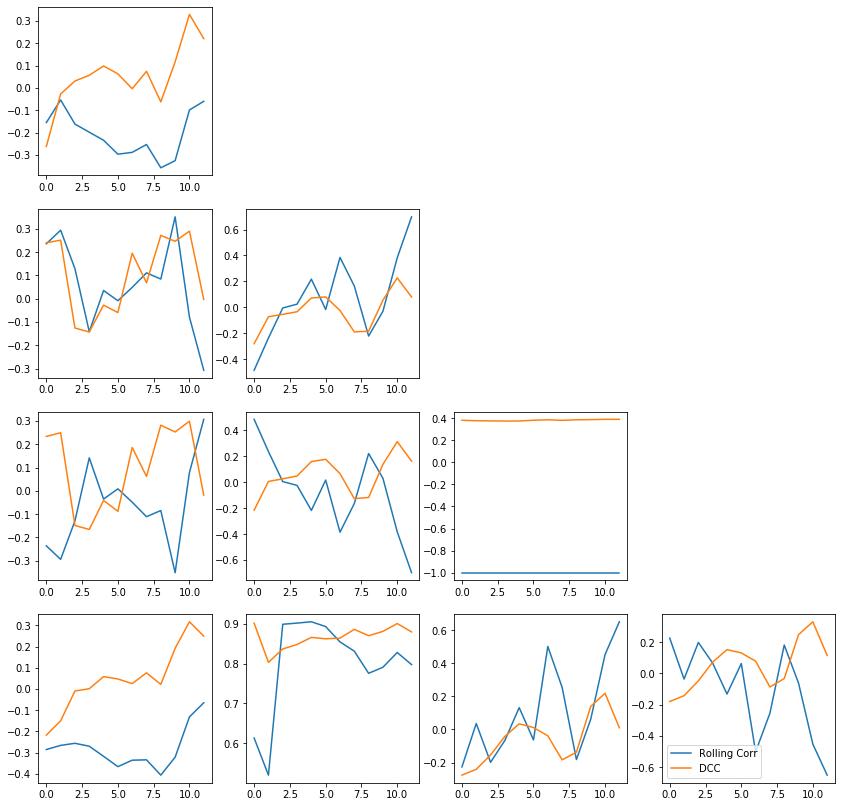

In [171]:
plot_forecast(forecast,forecast_names,data,length=12)
plt.savefig('correlations.png',dpi=300)
files.download('correlations.png')

In [23]:
mse_error,mae_error=calculate_error(forecast,forecast_names,data,min_length=min_length,max_length=max_length)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
top_10_lengths(mse_error,min_length=min_length,max_length=max_length)

,"1,0","2,0","2,1","3,0","3,1","3,2","4,0","4,1","4,2","4,3"
0,20,13,54,30,60,52,50,41,21,60
1,19,30,55,31,59,51,51,43,15,59
2,21,21,53,29,58,53,52,44,56,58
3,18,16,58,32,57,50,49,42,55,57
4,22,20,57,33,56,54,53,40,57,56
5,17,15,47,35,55,49,48,45,53,55
6,16,19,56,34,46,55,54,46,54,54
7,53,14,52,28,47,48,55,47,52,53
8,52,29,59,60,45,56,47,51,58,52
9,55,18,48,59,44,47,56,53,48,51


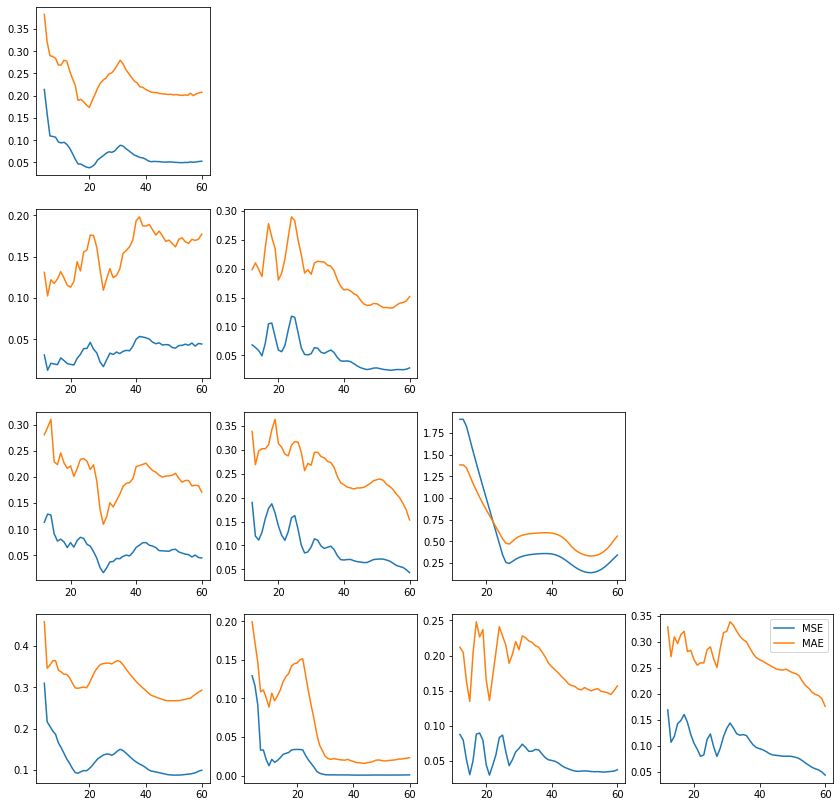

In [170]:
plot_matrix_errors(mse_error,mae_error)
plt.savefig('errors.png',dpi=300)
files.download('errors.png')

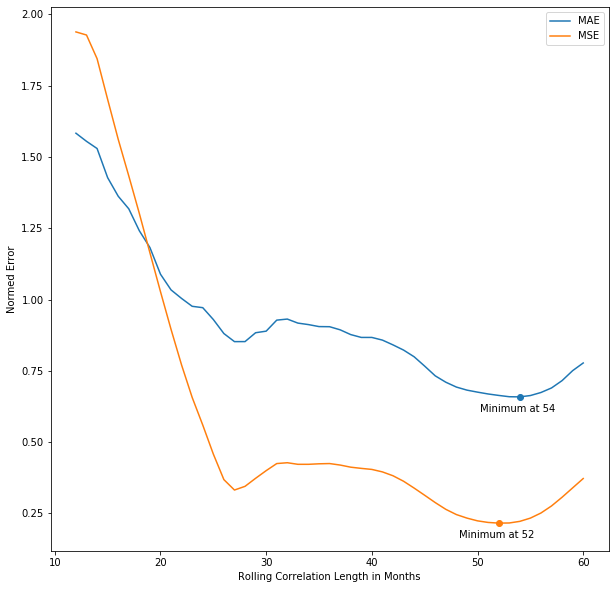

In [169]:
plot_norm_errors(mae_error,mse_error)
plt.savefig('normed_error.png',dpi=300)
files.download('normed_error.png')